# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__  Aland Astudillo, Campbell Border, Disheng Tang, Julia Yin, Koffivi, Rishabh Mallik, Shuwen Liu, Zelin Zhang

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
## Abstract

This study delves into the diverse methodologies employed for training neural networks, focusing specifically on one-step lookahead tasks such as the N-back memory task. In this task, participants are required to recognize and memorize stimuli displayed N steps prior, which serves as a standard evaluative measure of their short-term memory capabilities. Our research compares and contrasts two learning paradigms - classification and reinforcement learning - by training two distinct neural network models, a Multilayer Perceptron (MLP) and an Elman Recurrent Neural Network (RNN), using these methods.

Our hypothesis posits that although these training methods might initially generate varying short-term representations, they would ultimately converge to comparable outcomes. Moreover, we predict that the correlation between the training methods would be more pronounced in an MLP than an RNN, given their underlying structures and mechanisms.

To test these propositions, the two models were trained using both reinforcement learning and classification techniques, and their weight matrices were monitored at each epoch. Principal Component Analysis (PCA) and Canonical Correlation Analysis (CCA) were then employed to determine the correlation between these matrices.

In the pursuit of fairness and to optimize the comparative analysis, the hyperparameters of all models were carefully calibrated. Our findings have potential implications for understanding the learning dynamics of neural networks in short-term memory tasks.

---
# Setup

### Install Dependencies

In [1]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet
%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports

In [32]:
# @title Imports
import math
import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import register
from gymnasium import spaces
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import random

### Figure settings

In [2]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

- 1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks. 

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented. 

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.

https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
# Implementation

## Environment

The following cell registers and tests the N-back environment defined in the nback_env.py module. MORE INFO HERE

In [3]:
# @title Test and register environment

register(
    id='NBack-v0',
    entry_point='nback_env:NBack',
)

env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=5,
    rewards=(1, 0, 0, 0),
    num_obs=5,
    seed=42
    )

obs, info = env.reset()
print(env.sequence)
print(env.correct_actions)
done = False
while not done:
  obs, reward, done, info  = env.step(0)
  if obs[-1] == obs[-3]:
    print(env.step_count, obs, "MATCH")
  else:
    print(env.step_count, obs)

[3 0 3 0 4 3 7 7 6 2 0 0 2 5 6 5 5 5 2 5 7 1 4 0 0 4 2]
[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]
None
1 [0 0 0 3 0] MATCH
None
2 [0 0 3 0 3] MATCH
[0, 1]
3 [0 3 0 3 0] MATCH
[0, 1]
4 [3 0 3 0 4]
[1, 0]
5 [0 3 0 4 3]
[1, 0]
6 [3 0 4 3 7]
[1, 0]
7 [0 4 3 7 7]
[1, 0]
8 [4 3 7 7 6]
[1, 0]
9 [3 7 7 6 2]
[1, 0]
10 [7 7 6 2 0]
[1, 0]
11 [7 6 2 0 0]
[1, 0]
12 [6 2 0 0 2]
[1, 0]
13 [2 0 0 2 5]
[1, 0]
14 [0 0 2 5 6]
[1, 0]
15 [0 2 5 6 5] MATCH
[0, 1]
16 [2 5 6 5 5]
[1, 0]
17 [5 6 5 5 5] MATCH
[0, 1]
18 [6 5 5 5 2]
[1, 0]
19 [5 5 5 2 5] MATCH
[0, 1]
20 [5 5 2 5 7]
[1, 0]
21 [5 2 5 7 1]
[1, 0]
22 [2 5 7 1 4]
[1, 0]
23 [5 7 1 4 0]
[1, 0]
24 [7 1 4 0 0]
[1, 0]
25 [1 4 0 0 4]
[1, 0]
26 [4 0 0 4 2]
[1, 0]
27 [0 0 4 2 0]


/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment NBack-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: int64
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: W

In [41]:
# @title Replay memory class
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done, label, hidden=None):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done, label, hidden)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones, labels, hiddens = zip(*batch)
        return np.stack(states), actions, np.stack(next_states), rewards, dones, np.stack(labels), np.stack(hiddens)

    def __len__(self):
        return len(self.memory)

## Agents

In [6]:
# @title Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    # Choose a random action, 0 or 1
    def choose_action(self, seq):
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        # Arrays to hold true/false positives and false negatives
        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)

        for i in range(num_episodes):
            
            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Perform action for each element in sequence
            seq, info = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(seq)
                actions[info['step_count']] = action
                seq, reward, done, info = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) 
            fps[i] = np.dot(actions, 1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions)

        return tps, fps, fns

/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.episode_length to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_length` for environment variables or `env.get_attr('episode_length')` that will search the reminding wrappers.
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.N to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.N` for environment variables or `env.get_attr('N')` that will search the reminding wrappers.
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.correct_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get 

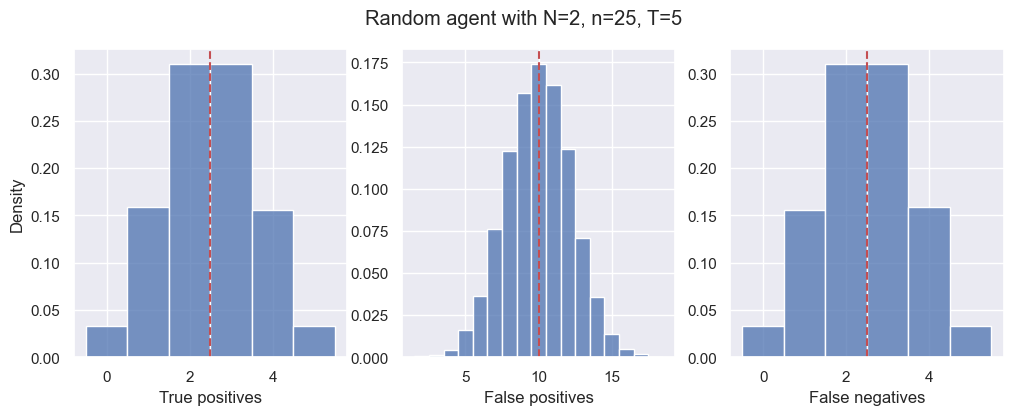

In [ ]:
# @title Test random agent
# Create environment, random agent and test
N = 2
n = 25
T = 5

env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=5,
    rewards=(1, 0, 0, 0),
    num_obs=5,
    seed=42
    )

agent = RandomAgent(env=env)
results = agent.test(10000)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
fig.suptitle(f"Random agent with N={N}, n={n}, T={T}")
sns.histplot(results[0], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('True positives')

plt.subplot(1, 3, 2)
sns.histplot(results[1], stat="density", bins=17, discrete=True)
plt.axvline((n-T)/2, color='r', linestyle='--')
plt.xlabel('False positives')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(results[2], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('False negatives')
plt.ylabel('')
plt.show()

### Neural networks

In [7]:
# Neural network representing the Q-function
class DQN(nn.Module):
  def __init__(self, input_size, output_size, hidden_sizes=[], actv="ReLU()"):
    super().__init__()

    self.input_size = input_size
    self.output_size = output_size
    self.hidden_sizes = hidden_sizes
    self.mlp = nn.Sequential()
    self.is_rnn = False

    # Create net
    prev_size = self.input_size # Initialize the temporary input feature to each layer
    for i in range(len(hidden_sizes)): # Loop over layers and create each one
        
        # Add linear layer
        current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
        layer = nn.Linear(prev_size, current_size)
        prev_size = current_size # Assign next layer input using current layer output
        self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

        # Add activation function
        actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
        self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(prev_size, self.output_size) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    x = torch.tensor(x, dtype=torch.float)
    return self.mlp(x)
    

In [8]:
# Simple RNN representing the Q-function
class SimpleRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(SimpleRNN, self).__init__()

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.hidden = torch.zeros(hidden_size)
        self.is_rnn = True
        self.temp = None
        self.hidden_size = hidden_size

    def forward(self, input):

        combined = torch.cat((input, self.hidden), -1)
        self.hidden = self.i2h(combined)
        output = self.h2o(self.hidden)

        if self.temp is not None:
            self.hidden = self.temp
            self.temp = None

        return output

    def add_temp_hiddens(self, hiddens):
        self.temp = self.hidden
        self.hidden = torch.tensor(hiddens)

    def reset_hidden(self):
        self.hidden = torch.zeros(self.hidden_size)

### Training and optimising functions

In [141]:
def train(models, memory, optimizers, criterions, batch_size, gamma, training=True):

    # Retrieve batch of interactions from memory
    if len(memory) < batch_size:
        return np.array([0]), np.array([0])
    states, actions, next_states, rewards, dones, labels, hiddens = memory.sample(batch_size)
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.LongTensor(actions))
    next_states = Variable(torch.FloatTensor(next_states))
    rewards = Variable(torch.FloatTensor(rewards))
    dones = Variable(torch.FloatTensor(dones))
    labels = Variable(torch.FloatTensor(labels))
    if models[0].is_rnn:
        hiddens = Variable(torch.FloatTensor(hiddens))
        model.add_temp_hiddens(hiddens) # Set hidden state of network to the previous hidden states

    # Get Q values and calculate loss
    q_values = models[0](states).gather(1, actions.unsqueeze(1)).squeeze(1)
    rl_loss = criterions[0](q_values, rewards.detach())

    # Run softmax and calculate loss
    outputs = F.softmax(models[1](states))
    class_loss = criterions[1](outputs, labels)

    # Backpropagate changes based on the gradient of the loss
    if training:
        optimizers[0].zero_grad()
        rl_loss.backward()
        optimizers[0].step()

        optimizers[1].zero_grad()
        class_loss.backward()
        optimizers[1].step()

    return rl_loss.detach(), class_loss.detach()


def exec_training(models, optimizers, criterions, env, gamma=0.99, num_episodes = 100, training=True):

    # Create an instance of the replay memory
    capacity = 1000
    memory = ReplayMemory(capacity)

    # Set hyperparameters
    batch_size = 64
    eps_max = 0.08
    eps_min = 0.01
    eps_step = 0.01

    # Create results arrays
    rl_tps = np.zeros(num_episodes)
    rl_fps = np.zeros_like(rl_tps)
    rl_fns = np.zeros_like(rl_tps)
    class_tps = np.zeros_like(rl_tps)
    class_fps = np.zeros_like(rl_tps)
    class_fns = np.zeros_like(rl_tps)
    correct = np.zeros_like(tps)
    rewards_list = []
    rl_loss_list = []
    class_loss_list = []
    rl_correct_list = []
    class_correct_list = []

    # Ignore the hidden state if 
    if not models[0].is_rnn:
        hidden = None

    # Training loop
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        actions = []
        if models[0].is_rnn:
            model.reset_hidden()

        step_count = 1
        while not done:
            # Select an action using epsilon-greedy policy
            epsilon = max(eps_min, eps_max - eps_step * episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    if models[0].is_rnn:
                        hidden = models[0].hidden.detach().numpy()
                    q_values = models[0](torch.FloatTensor(state))
                    action = q_values.argmax().item()

            # Take the selected action and observe the next state and reward
            next_state, reward, done, info = env.step(action)
            label = info["label"]

            # Store the transition in the replay memory
            if label is not None:
                memory.push(state, action, next_state, reward, done, label, hidden)

            # Move to the next state
            state = next_state
            total_reward += reward
            actions.append(action)

            # Train the model
            rl_loss, class_loss = train(models, memory, optimizers, criterions, batch_size, gamma, training)
            step_count += 1

            rl_loss_list.append(rl_loss.mean())
            class_loss_list.append(class_loss.mean())

        # Test models
        # if episode == num_episodes - 1:
        rl_correct, rl_tp, rl_fp, rl_fn = test_model(models[0], num_episodes=100)
        rl_correct_list.append(rl_correct)
        class_correct, class_tp, class_fp, class_fn = test_model(models[1], num_episodes=100)
        class_correct_list.append(class_correct)

        # Perform PCA on last weights matrix

        rewards_list.append(total_reward)
        actions = np.array(actions[env.N:])
        correct_actions = env.correct_actions
        # tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        # fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        # fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        rl_tps[episode] = rl_tp
        rl_fps[episode] = rl_fp
        rl_fns[episode] = rl_fn
        class_tps[episode] = class_tp
        class_fps[episode] = class_fp
        class_fns[episode] = class_fn

        

    return [rl_loss_list, class_loss_list], rewards_list, [rl_tps, class_tps], [rl_fps, class_fps], [rl_fns, class_fns], [rl_correct_list, class_correct_list]

def test_model(model, num_episodes):

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=5,
        rewards=(1, 0, -1, -1),
        num_obs=5,
        seed=42
        )

    tps = 0
    fps = 0
    fns = 0

    accuracy = 0

    for episode in range(num_episodes):
        
        state, _ = env.reset()
        done = False
        actions = []

        while not done:

            with torch.no_grad():
                output = model(torch.FloatTensor(state))
                action = output.argmax().item()

            # Take action and recieve next state
            next_state, _, done, info = env.step(action)

            # # Check if action was correct
            # if label is not None and label[action]:
            #     correct += 1
            actions.append(action)

            # Move to next state
            state = next_state
        
        # Calculate episode accuracy 
        actions = np.array(actions[env.N:])
        correct_actions = env.correct_actions
        accuracy += sum(actions == correct_actions) / env.num_trials
        tps += np.dot(actions, correct_actions) / (sum(correct_actions) * num_episodes)
        fps += np.dot(actions, 1 - correct_actions) / (sum(1 - correct_actions) * num_episodes)
        fns += np.dot(1 - actions, correct_actions) / (sum(correct_actions) * num_episodes)
    
    return accuracy / num_episodes, tps, fps, fns
    


### Run training/testing loops

In [146]:
# @title Run training/testing

# Create environment
env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=5,
    rewards=(1, 0, -1, -1),
    num_obs=5,
    seed=42
    )

# Create an instance of the model
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

rl_lr = 0.001
rl_model = DQN(input_size, output_size, hidden_sizes = [64, 64])
rl_optimizer = optim.Adam(rl_model.parameters(), lr=rl_lr)
rl_criterion = nn.MSELoss()
# rl_model = SimpleRNN(input_size, output_size, hidden_size=64)

class_lr = 0.001
class_model = DQN(input_size, output_size, hidden_sizes = [64, 64])
class_optimizer = optim.Adam(class_model.parameters(), lr=class_lr)
class_criterion = nn.CrossEntropyLoss()

models = [rl_model, class_model]
optimizers = [rl_optimizer, class_optimizer]
criterions = [rl_criterion, class_criterion]

# Run training
loss, rewards, tps, fps, fns, correct = exec_training(models, optimizers, criterions, env=env, gamma=0, num_episodes = 50)


/var/folders/z7/863rk6_120x23r3x_f3q_3300000gn/T/ipykernel_15591/3792078353.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1]
[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
[0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 0 1 0 0 0

/var/folders/z7/863rk6_120x23r3x_f3q_3300000gn/T/ipykernel_15591/1374908044.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(models[1](states))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0

### Plot results

/var/folders/z7/863rk6_120x23r3x_f3q_3300000gn/T/ipykernel_15591/3355047851.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


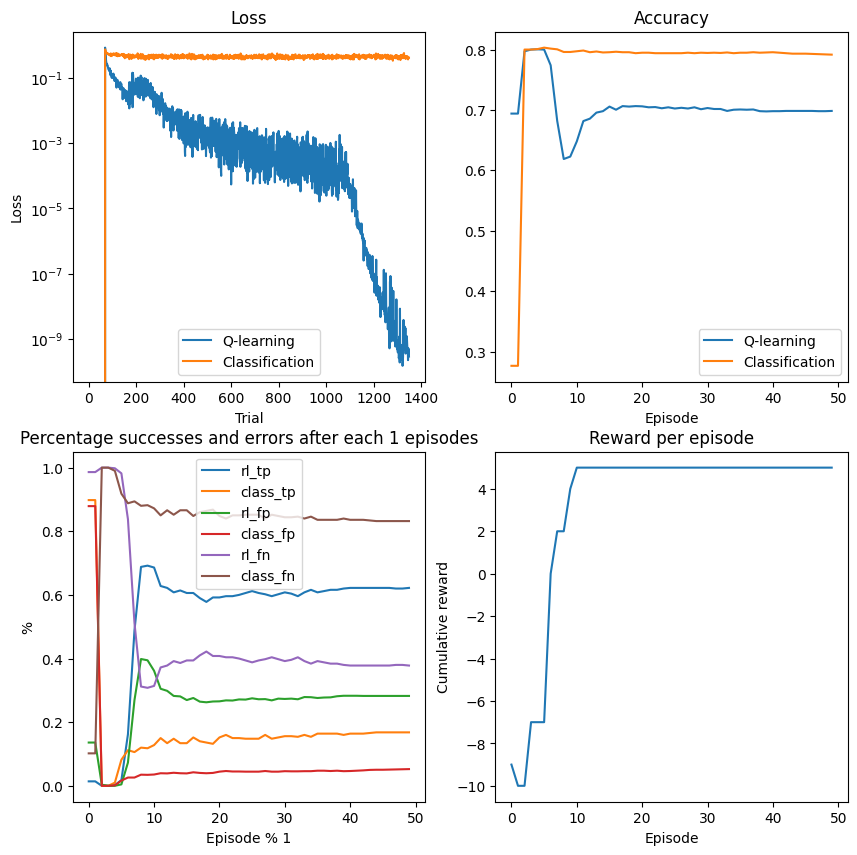

In [147]:
# @title Plot results

fig = plt.figure(figsize=(10, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(loss[0], '-')
plt.plot(loss[1], '-')
plt.title("Loss")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Trial")
plt.legend(["Q-learning", "Classification"])

# Reward
plt.subplot(2, 2, 4)
plt.plot(rewards, '-')
plt.title("Reward per episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")

# TPs, FPs, FNs
step = 1
plt.subplot(2, 2, 3)
plt.plot(tps[0])
plt.plot(tps[1])
plt.plot(fps[0])
plt.plot(fps[1])
plt.plot(fns[0])
plt.plot(fns[1])
plt.title(f"Percentage successes and errors after each {step} episodes")
plt.legend(["True positives", "False positives", "False negatives"])
plt.ylabel("%")
plt.xlabel(f"Episode")
fig.show()
plt.legend(["rl_tp", "class_tp","rl_fp", "class_fp","rl_fn", "class_fn"])

# Percentage correct
plt.subplot(2, 2, 2)
plt.plot(correct[0])
plt.plot(correct[1])
plt.title(f"Accuracy")
plt.xlabel(f"Episode")
plt.legend(["Q-learning", "Classification"])

### OTHER CODE

### Define a Recurrent Deep Q-learning Agent (RDQN)

In [ ]:
# RNN module: now is one RNN layer + 1 linear layer

class RNN(nn.Module):

  def __init__(self, num_obs, num_actions, hidden_size, layerdim = 1, actv="ReLU()"):
    super().__init__()

    self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_size = hidden_size
    self.layerdim = layerdim

    # Create net
    #input_size = self.num_obs # Initialize the temporary input feature to each layer
    self.rnn = nn.RNN(num_obs, hidden_size, layerdim, batch_first=False, nonlinearity='relu')
    self.fc = nn.Linear(hidden_size, num_actions)

  def forward(self, x):
      #h = torch.zeros(self.layerdim, x.size(0), self.hidden_size).requires_grad_()
      #print(x.shape, h.shape)
      outp = self.rnn(x)
      outp = self.fc(outp[:, -1, :])
      return outp

In [ ]:
def train(model, memory, optimizer, criterion, batch_size, gamma, training=True):
    if len(memory) < batch_size:
        return np.array([0])

    states, actions, next_states, rewards, dones = memory.sample(batch_size)
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.LongTensor(actions))
    next_states = Variable(torch.FloatTensor(next_states))
    rewards = Variable(torch.FloatTensor(rewards))
    dones = Variable(torch.FloatTensor(dones))

    print(states.shape)
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values.detach())

    if training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.detach()


def exec_training(model, env, gamma=0.99, num_episodes = 100, training=True):

    # Create an instance of the replay memory
    capacity = 1000
    memory = ReplayMemory(capacity)

    # Set hyperparameters
    batch_size = 64
    lr = 0.001
    eps_max = 0.08
    eps_min = 0.01
    eps_step = 0.01

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    tps = np.zeros(num_episodes)
    fps = np.zeros_like(tps)
    fns = np.zeros_like(tps)
    correct = np.zeros_like(tps)
    rewards_list = []
    loss_list = []

    # Training loop
    for episode in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        actions = []

        print(state)
        step_count = 1
        while not done:
            # Select an action using epsilon-greedy policy
            epsilon = max(eps_min, eps_max - eps_step * episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = model(torch.FloatTensor(state))
                    action = q_values.argmax().item()

            # Take the selected action and observe the next state and reward
            # next_state, reward, done, terminated, truncated = env.step(action)
            next_state, reward, done, info = env.step(action)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state
            total_reward += reward
            actions.append(action)

            # Train the model
            loss = train(model, memory, optimizer, criterion, batch_size, gamma, training)
            step_count += 1

            loss_list.append(loss.mean())

        rewards_list.append(total_reward)
        actions = np.array(actions[2:])
        correct_actions = env.correct_actions
        tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        correct[episode] = sum(actions == correct_actions) / env.num_trials

        # Print the total reward for the episode
        # print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    return loss_list, rewards_list, tps, fps, fns, correct

In [ ]:
for episodes in [5, 10, 50, 100, 500, 1000]:

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=5,
        rewards=(1, 0, -1, -1),
        num_obs=5,
        seed=42
        )

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    model = RNN(input_size, output_size, hidden_size = 64, layerdim = 1)

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = episodes)

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=5,
        rewards=(1, 0, -1, -1),
        num_obs=5,
        seed=21
        )

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = 500, training=False)

    print(episodes, correct.mean()*100)